# Check data from hubs

runnig with two hubs to check data dups %

Badges (running firmware 2.0):
* DB:97:55:CA:09:B2	397
* F8:2D:A1:09:CC:CE	398
* D4:9A:5C:60:CD:7A	399
* E3:8B:2C:9D:CB:6C	400
* F0:33:2C:A0:AE:DF	401


Beacons (running firmware 3.0):
* F7:6A:E2:C5:3C:0F
* F5:F6:CF:FB:95:4B
* F7:3A:AA:C7:30:E6



In [1]:
#import sys
#!{sys.executable} -m pip install sklearn

In [3]:
from __future__ import absolute_import, division, print_function

import pandas as pd
import numpy as np

import pytz
import gzip

# Import the data analysis tools
import openbadge_analysis as ob
import openbadge_analysis.preprocessing
import openbadge_analysis.core

In [4]:
# Settings
time_zone = 'US/Eastern' # Your local timezone
hublog_time_zone = 'UTC'
log_version = '2.0'
time_bins_size = '15S' # For proximity scans

folder = '../data/raw/20181130_hub_full_sync_old_hubs/'
proximity_filename = folder+'proximity_archive.txt.gz'
audio_filename = folder+'audio_archive.txt.gz'
hublog_filename = folder+'hub.log.gz'

In [5]:
# enables the %%R magic, not necessary if you've already done this
import readline
%load_ext rpy2.ipython 

%R -i time_zone timezone <- time_zone; print(timezone)

[1] "US/Eastern"


In [7]:
%%R
library(ggplot2)
library(scales)
rh_theme = theme(
    legend.title=element_text(size=2) , 
    legend.text=element_text(size=3)
    #panel.background=element_rect(fill="white"), # background=white
    #panel.grid.major.x=element_blank(), #no gridlines
    #panel.grid.minor.x=element_blank(), 
    #panel.grid.major.y=element_blank(), 
    #panel.grid.minor.y=element_blank(),
    #axis.text.x = element_text(angle=90, hjust = 1,vjust=1,size = 4,face = "bold"),
    #axis.text.y = element_text(size = 4)
)

# Load data

In [8]:
print("Loading voltage data (from proximity records)")
with gzip.open(proximity_filename, 'r') as f:
    voltages = ob.preprocessing.voltages(f, time_bins_size, tz=time_zone, skip_errors=True)

Loading voltage data (from proximity records)


In [9]:
print("Loading sample counts for proximity")
with gzip.open(proximity_filename, 'r') as f:
    proximity_sample_counts = ob.preprocessing.sample_counts(f, tz=time_zone, skip_errors=True)

print("Loading sample counts for audio")
with gzip.open(audio_filename, 'r') as f:
    audio_sample_counts = ob.preprocessing.sample_counts(f, tz=time_zone)


Loading sample counts for proximity
Loading sample counts for audio


In [10]:
print("Loading reset data")
with gzip.open(hublog_filename, 'r') as f:
    resets = ob.preprocessing.hublog_resets(f, log_tz = hublog_time_zone, tz=time_zone)

print("Loading clock sync data")
with gzip.open(hublog_filename, 'r') as f:
    clock_syncs = ob.preprocessing.hublog_clock_syncs(f, log_tz = hublog_time_zone, tz=time_zone)

Loading reset data
Loading clock sync data


In [11]:
# starting time
first_date = resets.index.get_level_values('datetime').min()
first_date

NaT

In [12]:
def to_relative_datetime(data):
    """ switch to relative time (since experiment started) """
    realtive_time = data.reset_index().copy()
    realtive_time['datetime'] = realtive_time['datetime'] - first_date
    realtive_time['day'] = realtive_time['datetime']/pd.Timedelta(days=1)
    return realtive_time

# Cleanup
Sometimes we get some records from the future or past. It's a bug, but it's so uncommon that we haven't found the reason yet


In [13]:
time_slice = slice('2018-10-01 00:00:00', '2018-12-05 20:00:00')

resets = resets.loc[time_slice, :]
voltages = voltages.loc[time_slice, :]

proximity_sample_counts.reset_index(level=1,inplace=True)
proximity_sample_counts = proximity_sample_counts.loc[time_slice, :]
proximity_sample_counts.set_index('member', append=True, inplace=True)

audio_sample_counts.reset_index(level=1,inplace=True)
audio_sample_counts = audio_sample_counts.loc[time_slice, :]
audio_sample_counts.set_index('member', append=True, inplace=True)

clock_syncs = clock_syncs.loc[time_slice, :]

# Count duplicate enteries

In [26]:
# Matplotlib for additional customization
from matplotlib import pyplot as plt
%matplotlib inline

# Seaborn for plotting and styling
import seaborn as sns

In [22]:
proximity_dup_counts = proximity_sample_counts.reset_index()[['datetime','member']]
proximity_dup_counts['ind'] = 1.0
proximity_dup_counts = proximity_dup_counts.groupby(['datetime','member']).count().reset_index()
proximity_dup_counts.tail(100)

,datetime,member,ind
56558,2018-12-02 14:07:20-05:00,1VHARYGJLU,1
56559,2018-12-02 14:07:24-05:00,HJ8OV7WYCJ,1
56560,2018-12-02 14:07:25-05:00,IAW553F7YB,1
56561,2018-12-02 14:07:27-05:00,MN5BZCVDBO,1
56562,2018-12-02 14:07:30-05:00,M5LM66H23V,1
56563,2018-12-02 14:07:35-05:00,1VHARYGJLU,1
56564,2018-12-02 14:07:39-05:00,HJ8OV7WYCJ,1
56565,2018-12-02 14:07:40-05:00,IAW553F7YB,1
56566,2018-12-02 14:07:42-05:00,MN5BZCVDBO,1
56567,2018-12-02 14:07:45-05:00,M5LM66H23V,1


In [23]:
proximity_dup_counts['ind'].value_counts()

1    51674
2     4984
Name: ind, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fac079ff410>]],
      dtype=object)

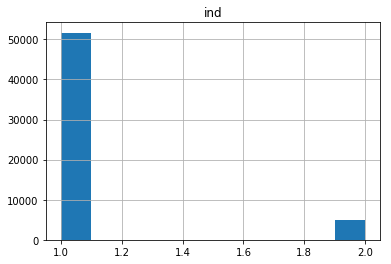

In [24]:
proximity_dup_counts.hist()

/home/orenled/.virtualenvs/openbadge-analysis-test-badge/local/lib/python2.7/site-packages/rpy2/robjects/pandas2ri.py:57: UserWarning: Error while trying to convert the column "datetime". Fall back to string conversion. The error is: Cannot pass numpy arrays with non-native byte orders at the moment.
  (name, str(e)))


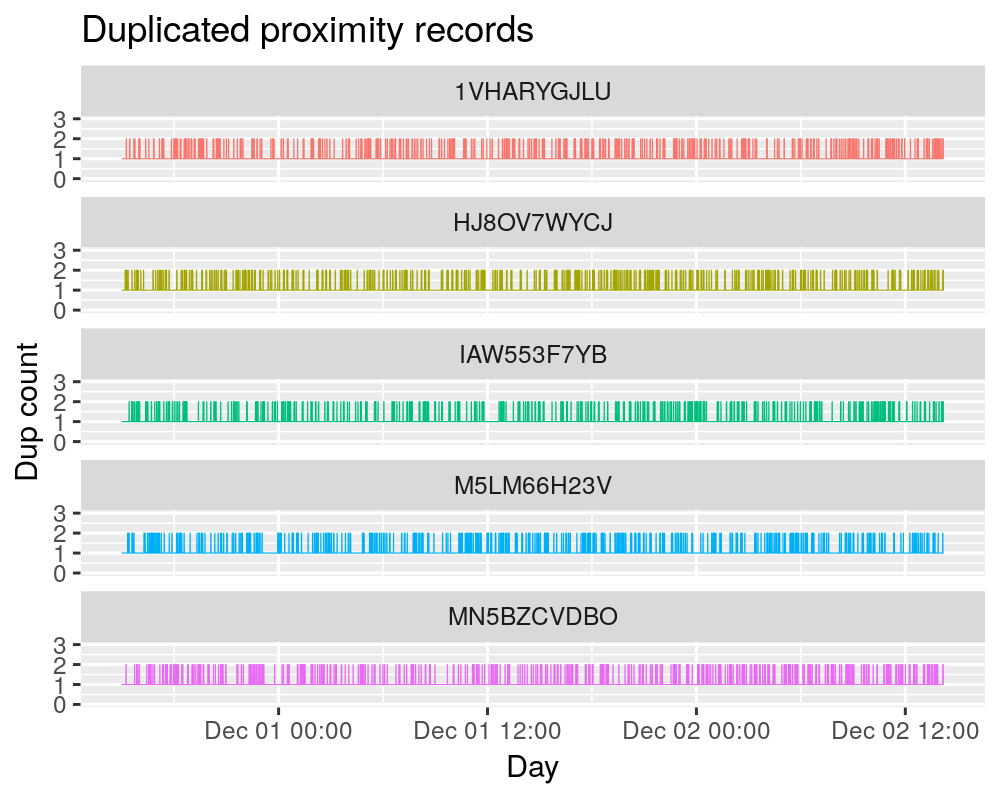

In [25]:
%%R -i proximity_dup_counts -w 5 -h 4 --units in -r 200
data <- proximity_dup_counts
data$datetime <- as.POSIXct(data$datetime, tz = timezone)

ggplot(data, aes(x = datetime, y = ind, color = member)) +
    geom_line(size=0.2) +
    facet_wrap( ~ member, ncol=1)+
    labs(title="Duplicated proximity records", x="Day", y="Dup count") +
    rh_theme +
    theme(legend.position="none") +
    ylim(0, 3)
